# Step #1 Loading the Data

In [24]:
# Tested with Python 3.8.8, Matplotlib 3.5, Seaborn 0.11.1, numpy 1.19.5, plotly 4.1.1, cufflinks 0.17.3, prophet 1.1.1, CmdStan 2.31.0

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from math import log, exp 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})
from scipy.stats import norm
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True)

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting quotes
stockname = 'Coca Cola'
symbol = 'KO'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Quick overview of dataset
print(df.head())

Installing CmdStan version: 2.31.0
Install directory: C:\Users\Flo\.cmdstan
CmdStan version 2.31.0 already installed


23:06:15 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\Flo\.cmdstan\RTools40


Installing CmdStan version: 2.31.0
Install directory: C:\Users\Flo\.cmdstan
CmdStan version 2.31.0 already installed
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  28.580000  28.610001  28.450001  28.520000  19.081615  13870400
2010-01-05  28.424999  28.495001  28.070000  28.174999  18.850792  23172400
2010-01-06  28.174999  28.219999  27.990000  28.165001  18.844103  19264600
2010-01-07  28.165001  28.184999  27.875000  28.094999  18.797272  13234600
2010-01-08  27.730000  27.820000  27.375000  27.575001  18.449356  28712400


<AxesSubplot: xlabel='Date', ylabel='Close'>

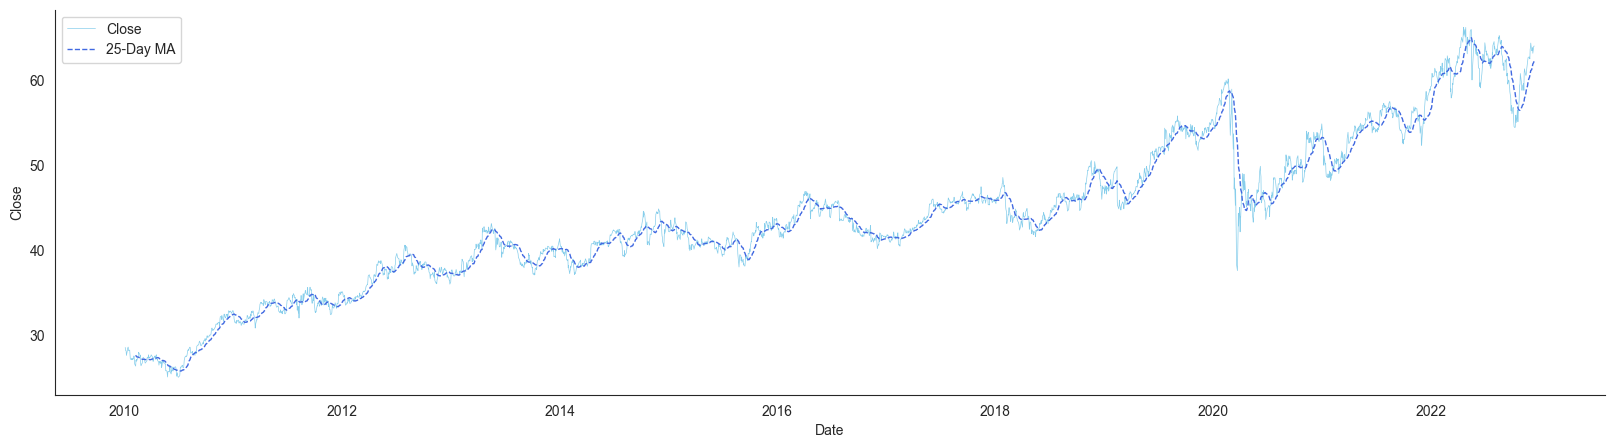

In [2]:
# Visualize the original time series
rolling_window=25
y_a_add_ma = df['Close'].rolling(window=rolling_window).mean() 

fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=df, x=df.index, y='Close', color='skyblue', linewidth=0.5, label='Close')
sns.lineplot(data=df, x=df.index, y=y_a_add_ma, 
    linewidth=1.0, color='royalblue', linestyle='--', label=f'{rolling_window}-Day MA')

# Step #2 Prepare the Data

In [3]:
df_x = df[['Close']].copy()
df_x['ds'] = df.index.copy()
df_x.rename(columns={'Close': 'y'}, inplace=True)
df_x.reset_index(inplace=True, drop=True)
df_x.dropna(inplace=True)
df_x.tail(3)

,y,ds
3258,63.970001,2022-12-12
3259,63.990002,2022-12-13
3260,63.990002,2022-12-14


# Step #3 Model Training and Forecasting

In [33]:
# This function fits the prophet model to the input data and generates a forecast
def fit_and_forecast(df, periods, interval_width, changepoint_range=0.8):

    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)

    # Fit the model
    model.fit(df)

    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods)

    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df


# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,24.653208,28.881220,26.779516
1,24.398624,29.045327,26.793064
2,24.556787,28.850875,26.767307
3,24.506933,28.974316,26.751868
4,24.448682,28.958195,26.748550


# Step #4 Analyzing the Forecast

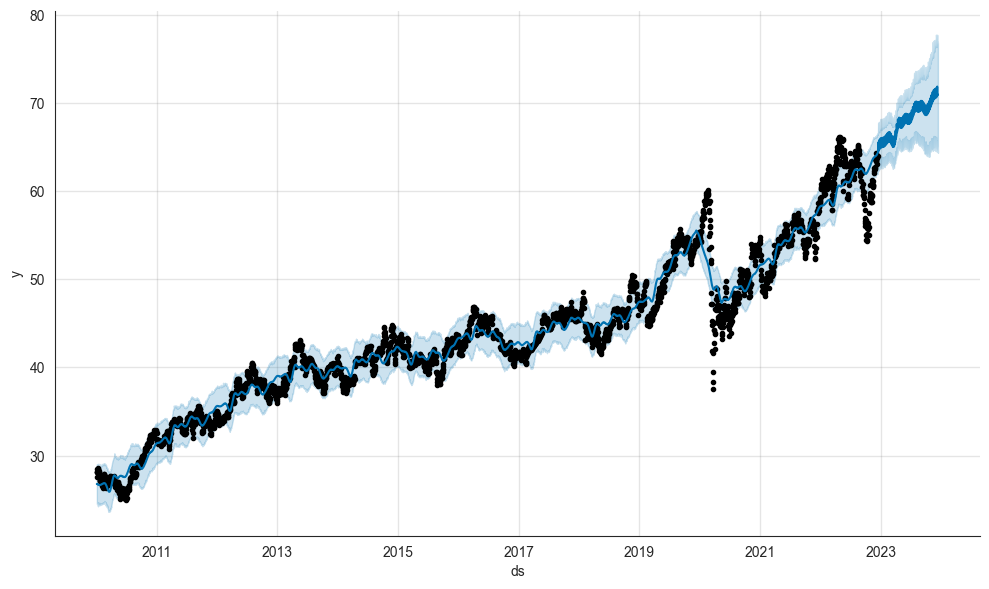

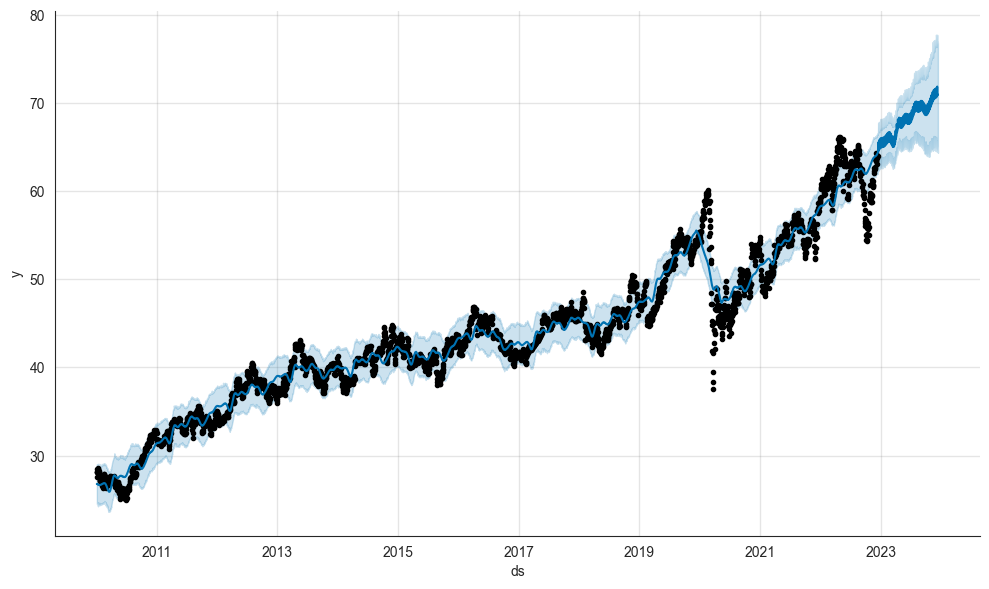

In [6]:
model.plot(forecast_df, uncertainty=True)

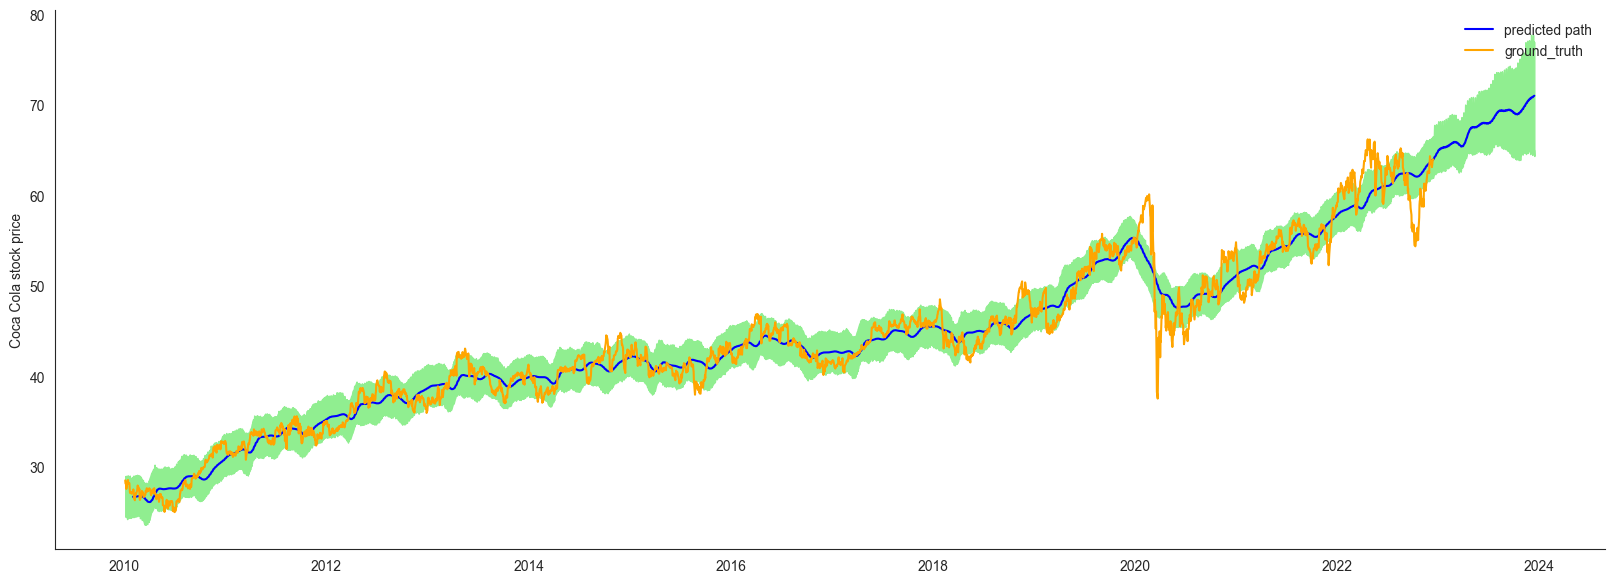

In [5]:
# Visualize the Forecast
def visualize_the_forecast(df_f, df_o):
    rolling_window = 20
    yhat_mean = df_f['yhat'].rolling(window=rolling_window).mean() 

    # Thin out the ground truth data for illustration purposes
    df_lim = df_o
    # Print the Forecast
    fig, ax = plt.subplots(figsize=[20,7])
    sns.lineplot(data=df_f, x=df_f.ds, y=yhat_mean, ax=ax, label='predicted path', color='blue')
    sns.lineplot(data=df_lim, x=df_lim.ds, y='y', ax=ax, label='ground_truth', color='orange')
    #sns.lineplot(data=df_f, x=df_f.ds, y='yhat_lower', ax=ax, label='yhat_lower', color='skyblue', linewidth=1.0)
    #sns.lineplot(data=df_f, x=df_f.ds, y='yhat_upper', ax=ax, label='yhat_upper', color='coral', linewidth=1.0)
    plt.fill_between(df_f.ds, df_f.yhat_lower, df_f.yhat_upper, color='lightgreen')
    plt.legend(framealpha=0)
    ax.set(ylabel=stockname + " stock price")
    ax.set(xlabel=None)

visualize_the_forecast(forecast_df, df_x)

# Step #5 Analyzing Model Components

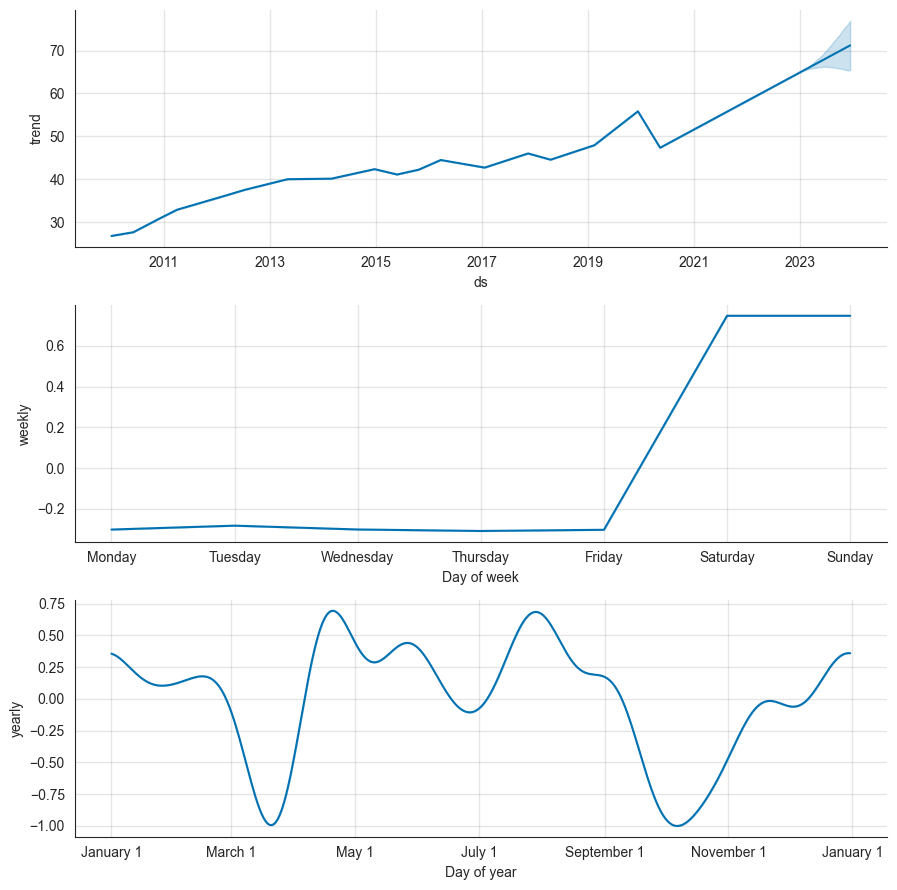

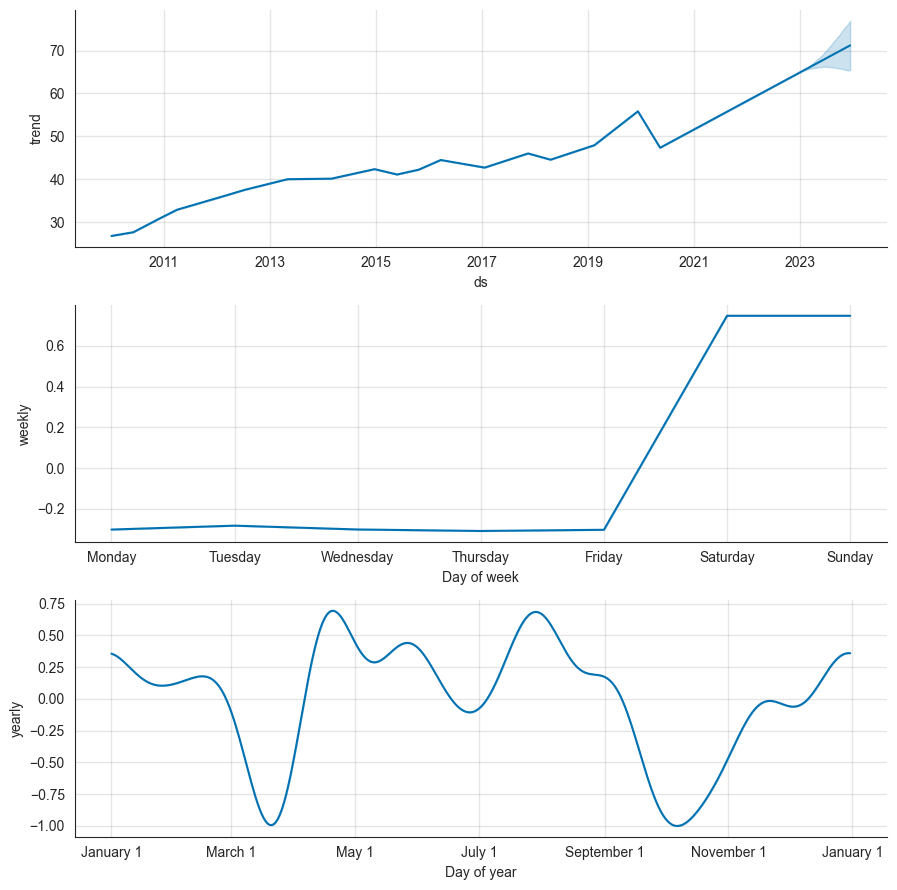

In [26]:
model.plot_components(forecast_df, True, weekly_start=1)

# Step #6 Adjusting the Changepoints of our Prophet Model

In [37]:
# Printing the ChangePoints of our Model
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 1.0)
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

23:42:05 - cmdstanpy - INFO - Chain [1] start processing


23:42:01 - cmdstanpy - INFO - Chain [1] start processing
23:42:02 - cmdstanpy - INFO - Chain [1] done processing


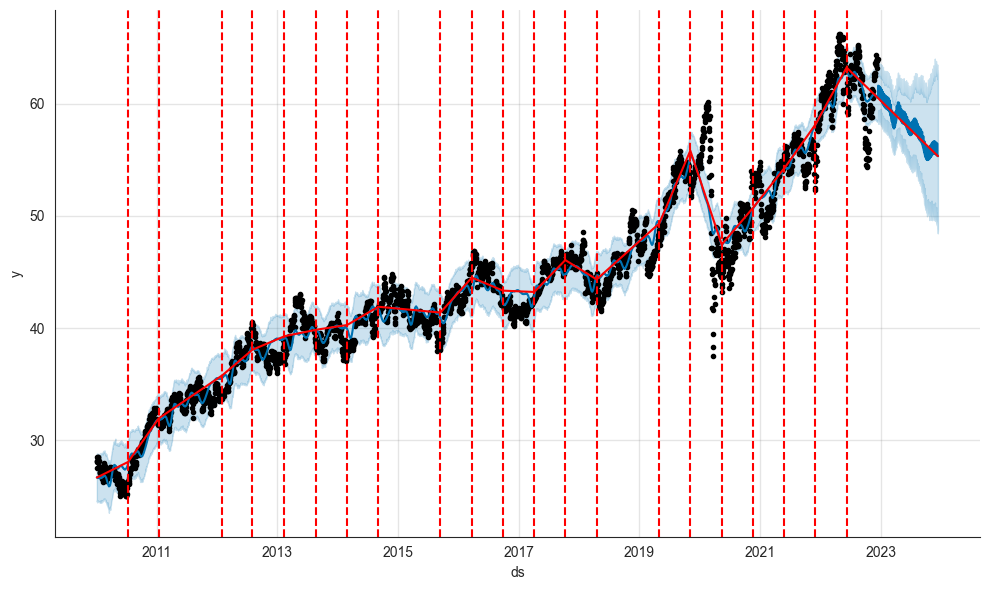

In [36]:
# Adjusting ChangePoints of our Model
forecast_df, model, future_df = fit_and_forecast(df_x, 365, 1.0, 1.0)
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)